In [231]:
def ready_datafram():
    selected_Col=['Date','Minimum temperature (°C)','Maximum temperature (°C)','Rainfall (mm)','Direction of maximum wind gust ','Speed of maximum wind gust (km/h)','Time of maximum wind gust','9am Temperature (°C)','9am relative humidity (%)','9am wind direction','9am wind speed (km/h)','9am MSL pressure (hPa)',	'3pm Temperature (°C)','3pm relative humidity (%)',	'3pm wind direction','3pm wind speed (km/h)','3pm MSL pressure (hPa)']
    df_weather= pd.read_csv('weather.csv',usecols=selected_Col)

    # Importing all columns from price_and_demand.csv in a DataFram(def_Consuming) 
    def_Consuming = pd.read_csv('price_and_demand.csv')

    # split SETTLEMENTDATE column in two columns(Date and Time)
    def_Consuming[['Date','Time']]=def_Consuming['SETTLEMENTDATE'].str.split(expand=True)
    # Rmove un_nessesory columns
    def_Consuming = def_Consuming.drop(columns=['SETTLEMENTDATE','REGION','RRP','PERIODTYPE','Time'])
    # Find mean of TOTALDamand for every Date
    def_Consuming_groupedBy=def_Consuming.groupby('Date')['TOTALDEMAND'].max()
    # Merge two df
    df = pd.merge(df_weather, def_Consuming_groupedBy, on='Date', how='inner')
    
    #fills null data in every column with the mean of the respective column.
    df['Maximum temperature (°C)'].fillna(df['Maximum temperature (°C)'].mean(), inplace=True)
    df['3pm Temperature (°C)'].fillna(df['3pm Temperature (°C)'].mean(), inplace=True)
    df['3pm relative humidity (%)'].fillna(df['3pm relative humidity (%)'].mean(), inplace=True)
    df['3pm MSL pressure (hPa)'].fillna(df['3pm MSL pressure (hPa)'].mean(), inplace=True)
    df['9am MSL pressure (hPa)'].fillna(df['9am MSL pressure (hPa)'].mean(), inplace=True)
    df['Speed of maximum wind gust (km/h)'].fillna(df['Speed of maximum wind gust (km/h)'].mean(), inplace=True)
    df['3pm wind speed (km/h)'].fillna(df['3pm wind speed (km/h)'].mean(), inplace=True)
    df['Direction of maximum wind gust '].fillna('SSW', inplace=True) # because We have 63 record with SSW (The max count)
    df['9am wind speed (km/h)'] = df['9am wind speed (km/h)'].replace('calm', '0')
    
    return df


In [232]:
def LinearRegressionML_PCA(df):

    # LinearRegression with selected feature based on  pearson + greedy methodes
    from sklearn.model_selection import train_test_split
    from sklearn.linear_model import LinearRegression
    from sklearn.metrics import mean_squared_error
    from sklearn.metrics import r2_score
    from sklearn.decomposition import PCA
    from sklearn.model_selection import cross_val_score, KFold
    from sklearn.metrics import make_scorer, r2_score
    from sklearn.datasets import make_regression
    
    X=df[['Minimum temperature (°C)','Maximum temperature (°C)','Rainfall (mm)','Speed of maximum wind gust (km/h)','9am Temperature (°C)','9am relative humidity (%)','9am wind speed (km/h)','9am MSL pressure (hPa)','3pm Temperature (°C)','3pm relative humidity (%)','3pm wind speed (km/h)','3pm MSL pressure (hPa)']]
    y = df['TOTALDEMAND']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
    pca = PCA(n_components=4) 
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)
    
    #Create a linear regression model
    model = LinearRegression()
    
   
    # Train the model
    model.fit(X_train_pca, y_train)

    # Make predictions on the testing set
    y_pred = model.predict(X_test_pca)
    # Evaluate the model
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    result_dec={'R-squared': r2 ,'mean_squared_error':mse,'Feature filtering ':f'{pca}' }
    return result_dec


In [233]:
def  LinearRegressionML_Manual(df):
        # LinearRegression with selected feature based on  pearson + greedy methodes
        from sklearn.model_selection import train_test_split
        from sklearn.linear_model import LinearRegression
        from sklearn.metrics import mean_squared_error
        from sklearn.metrics import r2_score
        from sklearn.decomposition import PCA
        
        X = df[['Maximum temperature (°C)','9am Temperature (°C)', '3pm relative humidity (%)']]
        y = df['TOTALDEMAND']

        # Split the data into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
        result_dec={}
        # Create a linear regression model
        model = LinearRegression()

        # Train the model
        model.fit(X_train, y_train)

        # Make predictions on the testing set
        
        y_pred = model.predict(X_test)
        # Evaluate the model
        mse = mean_squared_error(y_test, y_pred)
        
        r2 = r2_score(y_test, y_pred)
        result_dec={'R-squared': r2 ,'mean_squared_error':mse,'Feature filtering ':'Pearson Corelation + Greedy' ,'Selected Features':'Maximum temperature,9am Temperature,3pm relative humidity'}
        return result_dec

In [234]:
def Apply_ClusteringOnDemand(df):
        ################## Applied clustering on TotalDemand using K-means
        import pandas as pd
        import numpy as np
        from sklearn.cluster import KMeans
        import warnings


        df_ = pd.DataFrame({'Total Demand': df['TOTALDEMAND']})
        total_demand_values = np.array(df_['Total Demand']).reshape(-1, 1)

        # we choised the number of clusters besed on elbow diagram
        num_clusters = 3

        # Fit K-Means clustering model
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            clusters = KMeans(n_clusters=num_clusters, random_state=42)
            clusters.fit(total_demand_values)

        # Add the 'Cluster' column to the DataFrame. alias name is 'MaxDemand'
        df['MaxDemand'] = clusters.labels_
        return df

In [235]:
def DecisionTreeClassifierML(df):
        #DecisionTreeClassifier with filtering
        import pandas as pd
        import numpy as np
        from sklearn.tree import DecisionTreeClassifier
        from sklearn.model_selection import train_test_split
        from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif, mutual_info_regression
        from sklearn.metrics import accuracy_score
        from sklearn.model_selection import cross_val_score
        from sklearn.model_selection import KFold
        from sklearn.tree import DecisionTreeClassifier
        from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif, mutual_info_regression,f_classif
        from sklearn.model_selection import train_test_split
        from sklearn.tree import DecisionTreeClassifier
        from sklearn import tree
        from matplotlib import pyplot as plt


        tree_attribute={}
        y = df['MaxDemand']
        ############## feature selection Via fs method for finding best Xs
        all_features=df[['Maximum temperature (°C)','Minimum temperature (°C)','Speed of maximum wind gust (km/h)','9am Temperature (°C)','9am relative humidity (%)','9am wind speed (km/h)','3pm relative humidity (%)','3pm wind speed (km/h)']]
        
        k_best = SelectKBest(score_func=f_classif, k=4)
        X_new = k_best.fit_transform(all_features, y)
        # Get the indices of the selected features
        selected_feature_indices = k_best.get_support(indices=True)
        # Get the names of the selected features
        selected_feature_names = all_features.columns[selected_feature_indices]
        #################  X ################
        X=df[selected_feature_names]
        #################################################
        # we find depth=4 with Gride algorithm

        dt = DecisionTreeClassifier(random_state=1, max_depth=4)

        kf = KFold(n_splits=10, shuffle=True, random_state=42)

        # Perform k-fold cross-validation
        cross_val_results = cross_val_score(dt, X, y, cv=kf, scoring='accuracy')
        #print(dt.criterion) 
        tree_attribute={'Average Accuracy ': format(cross_val_results.mean() * 100)
                        ,'max depth ':f'{dt.max_depth} (based on Gride algorithm)' 
                        ,'Clustering algorithm ': 'K_mean(k=3)'
                        ,'criterion ':dt.criterion
                        ,'Feature filtering ': f'Chi-square {k_best})'
                        ,'Selected features': selected_feature_names
                        ,'Splitting Strategies ': kf
                       }
                              
       
        return tree_attribute

  

In [236]:
def KNNClassifierML(df):
        import pandas as pd
        import matplotlib.pyplot as plt
        import numpy as np

        from sklearn import neighbors
        from sklearn.model_selection import train_test_split
        from sklearn.metrics import accuracy_score
        from sklearn import preprocessing
        from sklearn.impute import SimpleImputer
        from sklearn.model_selection import KFold
        from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif, mutual_info_regression,f_classif

        knn_attribute={}
        
        ##get  the class labels
        y = df['MaxDemand']
        ############## get the best feature  Via fs method for finding  Xs
        all_features=df[['Maximum temperature (°C)','Minimum temperature (°C)','Speed of maximum wind gust (km/h)','9am Temperature (°C)','9am relative humidity (%)','9am wind speed (km/h)','3pm relative humidity (%)','3pm wind speed (km/h)']]
        
        k_best = SelectKBest(score_func=f_classif, k=4)
        X_new = k_best.fit_transform(all_features, y)
        # Get the indices of the selected features
        selected_feature_indices = k_best.get_support(indices=True)
        # Get the names of the selected features
        selected_feature_names = all_features.columns[selected_feature_indices]
        # Assigning best feature to X
        X=df[selected_feature_names]
        #################################################
        
        k=10
        kf = KFold(n_splits=k, shuffle=True, random_state=42)
        acc_score = []
        for train_index, test_index in kf.split(X):
            #Perform the split for this fold
            X_train, X_test = X.iloc[train_index, :], X.iloc[test_index, :]
            y_train, y_test = y[train_index], y[test_index]

            #Scale the data
            scaler = preprocessing.StandardScaler().fit(X_train)
            X_train=scaler.transform(X_train)
            X_test=scaler.transform(X_test)

            #Impute missing values via mean imputation
            imp = SimpleImputer(missing_values=np.nan, strategy='mean')
            X_train = imp.fit_transform(X_train)
            X_test = imp.transform(X_test)

            #Train k-nn classifier
            knn = neighbors.KNeighborsClassifier(n_neighbors=5)
            knn.fit(X_train, y_train)

            #Predict result
            y_pred=knn.predict(X_test)
            acc_score.append(accuracy_score(y_test, y_pred))

        
        knn_attribute={'avg_acc_scorec':sum(acc_score)/k,'acc_score':acc_score, 'Feature filtering ': f'Chi-square {k_best})'
                        ,'Selected features': selected_feature_names
                        ,'Clustering algorithm ': 'K_mean(k=3)'
                        ,'Splitting Strategies ': kf }
        return knn_attribute

In [237]:
def best_K_with_elbow(df):

    #Elbow Method
    import numpy as np
    import matplotlib.pyplot as plt
    from sklearn.cluster import KMeans
    from sklearn.metrics import pairwise_distances_argmin_min
    import warnings

    # Assuming total_demand_values is a NumPy array or a Pandas Series containing 'Total Demand' values
    total_demand_values = np.array(df['TOTALDEMAND']).reshape(-1, 1)

    # Define a range of possible values for K
    k_values = range(1, 11)

    # Calculate the sum of squared distances for each K
    inertia_values = []

    # Suppress warnings during the KMeans fitting
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")

        for k in k_values:
            kmeans = KMeans(n_clusters=k, random_state=42)
            kmeans.fit(total_demand_values)
            inertia_values.append(kmeans.inertia_)

    # Plot the Elbow curve
    plt.plot(k_values, inertia_values, marker='o')
    plt.xlabel('Number of Clusters (K)')
    plt.ylabel('Sum of Squared Distances (Inertia)')
    plt.title('Elbow Method')
    plt.show()

*********************************
The result of linear Regression:
{'R-squared': 0.46740507594125547, 'mean_squared_error': 423557.0621373907, 'Feature filtering ': 'Pearson Corelation + Greedy', 'Selected Features': 'Maximum temperature,9am Temperature,3pm relative humidity'}

*********************************
The result  linear Regression with PCA:
{'R-squared': 0.375503333903755, 'mean_squared_error': 496643.8117557904, 'Feature filtering ': 'PCA(n_components=4)'}

*********************************
*********************************

*********************************
*****  Apply elbow method to find best K for K_mean algorithm **



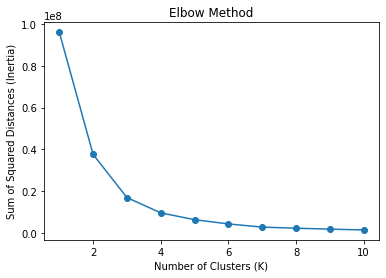


*********************************
*********************************
****** Decision Tree Modle Result ******

****   Average Accuracy  : 70.22875816993464
****   max depth  : 4 (based on Gride algorithm)
****   Clustering algorithm  : K_mean(k=3)
****   criterion  : gini
****   Feature filtering  : Chi-square SelectKBest(k=4))
****   Selected features : Index(['Maximum temperature (°C)', 'Minimum temperature (°C)',
       '9am Temperature (°C)', '3pm relative humidity (%)'],
      dtype='object')
****   Splitting Strategies  : KFold(n_splits=10, random_state=42, shuffle=True)

*********************************
*********************************
****** KNN Modle Result ******

****   avg_acc_scorec : 0.7480392156862745
****   acc_score : [0.8333333333333334, 0.7647058823529411, 0.8823529411764706, 0.5882352941176471, 0.6470588235294118, 0.7058823529411765, 0.7647058823529411, 0.8235294117647058, 0.7058823529411765, 0.7647058823529411]
****   Feature filtering  : Chi-square SelectKBest(k

In [239]:
##### Main Program ###########
##############################
import pandas as pd
from sklearn import tree
from matplotlib import pyplot as plt

# This function selects non-null columns from weather.csv and merges them with the maximum TOTALDEMAND on each day into a dataframe.
# and  fills null data in every column with the mean of the respective column.
result_df=ready_datafram()

print (f"*********************************\nThe result of linear Regression:\n{LinearRegressionML_Manual(result_df)}\n")
print (f"*********************************\nThe result  linear Regression with PCA:\n{LinearRegressionML_PCA(result_df)}\n")
print('*********************************\n*********************************\n')
print('*********************************\n*****  Apply elbow method to find best K for K_mean algorithm **\n')
best_K_with_elbow(result_df)
result_df=Apply_ClusteringOnDemand(result_df)
print('\n*********************************\n*********************************\n****** Decision Tree Modle Result ******\n')
for key, value in DecisionTreeClassifierML(result_df).items():
    print(f'****   {key} : {value}')
print('\n*********************************\n*********************************\n****** KNN Modle Result ******\n')

for key, value in KNNClassifierML(result_df).items():
    print(f'****   {key} : {value}')
print('*********************************\n*********************************\n')
 